In [16]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [211]:
# Include libraries which may use in implementation
import numpy as np
import random
import math
import pickle
from sklearn.utils import shuffle
import glob
import cv2 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
%matplotlib inline

In [213]:
def loadDataset(path):
    print('Loading Dataset...')
    train_x, train_y, test_x, test_y = [], [], [], []
    for i in range(10):
        for filename in glob.glob(path + '\\train\\' + str(i)+'\\*.png'):
            im = cv2.imread(filename,0) #reading in greyscale
            train_x.append(im)
            train_y.append(i)
    for i in range(10):
        for filename in glob.glob(path + '\\test\\' + str(i)+'\\*.png'):
            im=cv2.imread(filename,0)
            test_x.append(im)
            test_y.append(i)
    print('Dataset loaded...')
    return np.array(train_x), np.array(train_y), np.array(test_x),np.array(test_y)

In [214]:
path = 'D:\study material\MSDS-ITU\semester2\DL\Assignments\Assignment2\Task3_Data'
train_set_x, train_set_y, test_set_x, test_set_y = loadDataset (path)

Loading Dataset...
Dataset loaded...


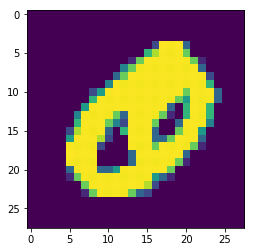

In [215]:
plt.imshow(train_set_x[0])

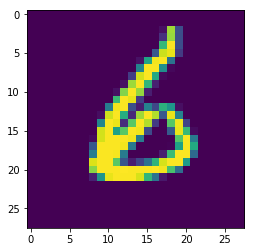

In [217]:
plt.imshow(train_set_x[37880])

In [218]:
print( "train_set_x.shape : ",train_set_x.shape ,"\n train_set_y.shape: ", train_set_y.shape,"\n test_set_x.shape: ", test_set_x.shape, "\n  test_set_y.shape :",test_set_y.shape, "\n")

train_set_x.shape :  (60000, 28, 28) 
 train_set_y.shape:  (60000,) 
 test_set_x.shape:  (10000, 28, 28) 
  test_set_y.shape : (10000,) 



In [219]:
#Converting into our required dimensions given in pdf
train_set_y=np.expand_dims(train_set_y, axis=1)
test_set_y = np.expand_dims(test_set_y, axis=1)
train_set_x=np.expand_dims(train_set_x, axis=3)
test_set_x = np.expand_dims(test_set_x, axis=3)
print( "train_set_x.shape : ",train_set_x.shape ,"\n train_set_y.shape: ", train_set_y.shape,"\n test_set_x.shape: ", test_set_x.shape, "\n  test_set_y.shape :",test_set_y.shape, "\n")

train_set_x.shape :  (60000, 28, 28, 1) 
 train_set_y.shape:  (60000, 1) 
 test_set_x.shape:  (10000, 28, 28, 1) 
  test_set_y.shape : (10000, 1) 



In [220]:
#Image Flattening
X_train = train_set_x.reshape(train_set_x.shape[0],
                         (28*28))
X_test = test_set_x.reshape(test_set_x.shape[0],
                         (28*28))
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [221]:
s_Xtrain = X_train - X_train.mean()
s_Xtest = X_test - X_train.mean()

In [222]:
X, y = shuffle(s_Xtrain, train_set_y)

In [223]:
trainPercentage = 0.80
testPercantage= 0.20

trainX = X[:int(trainPercentage * len(X))] # training data point
trainY = y[:int(trainPercentage * len(y))] # training lables

validX = X[int(trainPercentage * len(X)) :  ] # validation data point
validY = y[int(trainPercentage * len(y))  :   ]# validation lables
print("training sizes: ",len(trainX), len(validX), len(s_Xtest))

training sizes:  48000 12000 10000


In [253]:
# Create a Neural_Network class
class Neural_Network(object):    
    def __init__(self,no_of_layers = 2, input_dim = 784, neurons_per_layer =[128,64,10]):        
        # size of layers
        self.inputSize = input_dim
        
        #weights
        self.W1 = np.random.rand(input_dim, neurons_per_layer[0])
        self.b1 = np.random.rand(neurons_per_layer[0])
        self.W2 = np.random.rand(neurons_per_layer[0], neurons_per_layer[1] )
        self.b2 = np.random.rand(neurons_per_layer[1])
        self.W3 = np.random.rand(neurons_per_layer[1], neurons_per_layer[2] )
        self.b3 = np.random.rand(neurons_per_layer[2])
        
    def Encode(self,l):
        c = np.arange(10)
        one_hot = (c == l).astype(np.int)
        return one_hot    
    
    def feedforward(self, X):
        
        self.l1 = np.dot(X, self.W1) #+ self.b1 
        self.a1 = self.sigmoid(self.l1)
        self.l2 = np.dot(self.a1, self.W2) #+ self.b2  
        self.a2 = self.sigmoid(self.l2)
        self.l3 = np.dot(self.a2, self.W3) #+ self.b3 
        self.a3 = self.softmax(self.l3)
#         print( "y_pred shape",self.a3.shape)
        return self.a3
        
    def softmax(self, X):
        
        exps = np.exp(X - np.max(X))
        return exps / np.sum(exps, axis=1, keepdims= True)
    

    def softmax_derivative(softmax):
        s = softmax.reshape(-1,1)
        return np.diagflat(s) - np.dot(s, s.T)


    def sigmoid(self, s):
        # activation function
        return (1/ (1 + np.exp(-s))) # apply sigmoid function on s and return it's value

    def sigmoid_derivative(self, s):
        #derivative of sigmoid
#         s = self.sigmoid(s)
        sigmoidDerivative = s * (1 - s)
        return sigmoidDerivative # apply derivative of sigmoid on s and return it's value 

    def tanh(self, s):
        # activation function
        
        return (np.exp(s) - np.exp(-s)) / (np.exp(s) + np.exp(-s)) # apply tanh function on s and return it's value

    def tanh_derivative(self, s):
        #derivative of tanh
        
        return 1 - (s)**2
    def backwardpropagate(self,X, Y, y_pred, lr):


        z3 = (y_pred- Y)# * (y_pred- Y)
        
        dw3 = np.dot(self.a2.T, z3)/Y.shape[0]
        self.W3 -= lr * dw3
        z2 = np.multiply(z3.dot(self.W3.T), self.sigmoid_derivative(self.a2))
        dw2 = np.dot(self.a1.T, z2)/Y.shape[0]
        self.W2 -= lr * dw2
       
        z1 = np.multiply(z2.dot(self.W2.T), self.sigmoid_derivative(self.a1))
        dw1 = np.dot(X.T, z1)/Y.shape[0]
        self.W1 -= lr * dw1
        
        

   
    
    def crossentropy(self, Y, Y_pred):
#         return np.sum((Y - Y_pred)**2) / len(Y)
#         # compute error based on crossentropy loss
        #error = - np.sum((Y * np.log (Y_pred)) + ((1-Y)* np.log (1- Y_pred)))
        cerror = - np.sum(Y * np.log2 (Y_pred + 1e-8)) /len(Y)
        return cerror #error

    def train(self, trainX, trainY,epochs = 100, learningRate = 0.001, plot_err = True ,validationX = 'Null', validationY = 'Null'):
        # feed forward trainX and trainY and recivce predicted value
        # backpropagation with trainX, trainY, predicted value and learning rate.
        # if validationX and validationY are not null than show validation accuracy and error of the model.
#         trainX /= 255
#         validationX /= 255
        
        validationY = self.Encode(validationY)
        trainY = self.Encode(trainY)
        errorTrain =[]
        errorValid =[]
        ValidationAccuracy =[]
        TraingingAccuracy = []
        for i in range(epochs): 
            prediction = self.feedforward(trainX)
            self.backwardpropagate(X=trainX, Y=trainY, y_pred= prediction,lr= learningRate )
            errorTrain.append(self.crossentropy(Y=trainY,Y_pred = prediction ))
#             print("errorTrain: ", errorTrain[-1])
            errorValid.append(self.crossentropy(validationY, self.feedforward(validationX)))
#             print("errorValid: ", errorValid[-1])
            ValidationAccuracy.append(self.accuracy(validationX,validationY))
            TraingingAccuracy.append(self.accuracy(trainX,trainY))
            print("at epoch: ",i," ValidationAccuracy: ", ValidationAccuracy[-1], "TraingingAccuracy", TraingingAccuracy[-1])
        
        
        
        if(plot_err): #Training Loss
            plt.plot(range(epochs), errorTrain, label = 'Training loss curve')
            plt.legend()
            plt.title('loss curves using activation function ')
        if(validationX != 'Null' and validationY != 'Null'):
            plt.plot(range(epochs), errorValid, label = 'Validation loss curve')
            plt.legend()
            plt.xlabel('Epochs') 
            plt.ylabel('Entropy Loss') 
            plt.show()
            
            plt.plot(range(epochs), TraingingAccuracy, label = 'Trainging accuracy')
            plt.plot(range(epochs), ValidationAccuracy, label = 'Validation accuracy')
            plt.legend()
            plt.title('Accuracy curves using activation function ' )
            plt.xlabel('Epochs') 
            plt.ylabel('Accuracy') 
            plt.show()
        
    def predict(self, testX):
        # predict the value of testX
        return self.feedforward(testX)
    
    def accuracy(self, x, Y):
        TP =0
#          # Do a prediction with the model
        A = self.predict(x)
        

        for i in range(len(Y)):
            if(np.argmax(A[i]) == np.argmax(Y[i])):
                TP +=1
        _accuracy = (TP ) / len(Y)
        _accuracy *= 100
        print(_accuracy)
        return (_accuracy)
          
        
    def saveModel(self,name):
        # save your trained model, it is your interpretation how, which and what data you store
        # which you will use later for prediction
        print('saving model')
        saved_model = np.save('msds19027_task3_01.npy', self.W1)
        saved_model1 = np.save("msds19027_task3_02.npy", self.W2)
        saved_model2 = np.save("msds19027_task3_03.npy", self.W3)
        print('model saved..')
        
    def loadModel(self,name):
        # load your trained model, load exactly how you stored it.
        self.W1= np.load("msds19027_task3_01.npy" )
        self.W2= np.load("msds19027_task3_02.npy")
        self.W3= np.load("msds19027_task3_03.npy")
        print(self.W1)
        print(self.W2)
        print(self.W3)


9.966666666666667
9.845833333333333
at epoch:  0  ValidationAccuracy:  9.966666666666667 TraingingAccuracy 9.845833333333333
9.966666666666667
9.847916666666666
at epoch:  1  ValidationAccuracy:  9.966666666666667 TraingingAccuracy 9.847916666666666
9.975000000000001
9.866666666666667
at epoch:  2  ValidationAccuracy:  9.975000000000001 TraingingAccuracy 9.866666666666667
10.0
9.883333333333333
at epoch:  3  ValidationAccuracy:  10.0 TraingingAccuracy 9.883333333333333
10.0
9.883333333333333
at epoch:  4  ValidationAccuracy:  10.0 TraingingAccuracy 9.883333333333333
10.025
9.889583333333334
at epoch:  5  ValidationAccuracy:  10.025 TraingingAccuracy 9.889583333333334
10.008333333333333
9.891666666666667
at epoch:  6  ValidationAccuracy:  10.008333333333333 TraingingAccuracy 9.891666666666667
10.05
9.902083333333334
at epoch:  7  ValidationAccuracy:  10.05 TraingingAccuracy 9.902083333333334
10.058333333333334
9.897916666666665
at epoch:  8  ValidationAccuracy:  10.058333333333334 Train

10.141666666666667
9.995833333333334
at epoch:  71  ValidationAccuracy:  10.141666666666667 TraingingAccuracy 9.995833333333334
10.141666666666667
9.997916666666667
at epoch:  72  ValidationAccuracy:  10.141666666666667 TraingingAccuracy 9.997916666666667
10.133333333333333
9.997916666666667
at epoch:  73  ValidationAccuracy:  10.133333333333333 TraingingAccuracy 9.997916666666667
10.133333333333333
9.995833333333334
at epoch:  74  ValidationAccuracy:  10.133333333333333 TraingingAccuracy 9.995833333333334
10.133333333333333
9.99375
at epoch:  75  ValidationAccuracy:  10.133333333333333 TraingingAccuracy 9.99375
10.133333333333333
9.995833333333334
at epoch:  76  ValidationAccuracy:  10.133333333333333 TraingingAccuracy 9.995833333333334
10.133333333333333
9.995833333333334
at epoch:  77  ValidationAccuracy:  10.133333333333333 TraingingAccuracy 9.995833333333334
10.141666666666667
9.995833333333334
at epoch:  78  ValidationAccuracy:  10.141666666666667 TraingingAccuracy 9.995833333333

D:\Installed\Anaconda\lib\site-packages\ipykernel_launcher.py:117: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


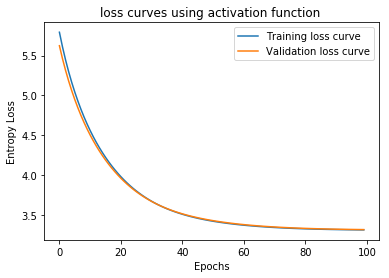

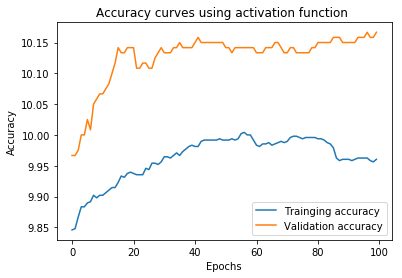

In [241]:
from sklearn.metrics import confusion_matrix
model = Neural_Network(2,784, [128,64,10])
# try different combinations of epochs and learning rate
model.train(trainX, trainY, epochs = 100, learningRate = 0.01, validationX = validX, validationY = validY)

In [242]:
test_set_y = model.Encode(test_set_y)
model.accuracy(s_Xtest,test_set_y)

96.76


96.76

In [254]:
model.saveModel('s')

saving model
model saved..


In [256]:
mm = Neural_Network()
# load model which will be provided by you
mm.loadModel('s')
# check accuracy of that model
mm.accuracy(testX,testY)